# HEAD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import warnings
import pandas as pd
import import_ipynb

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import SSG
from Spike_Generation import NL
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater

warnings.filterwarnings('ignore')
%matplotlib inline

importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


In [2]:
def NGD2LS_TK(T, alpha, g, l, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/20
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    #Simplifed Part
    beta = alpha
    gamma = 1./tau_y
    
    
    
    
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta*z[j]  + g*y[j] )
        dw=dt*(-gamma*w[j] + y[j]-l*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw

    nTK = w[::20]/(dt) #normalized by integration
    return -Amp*nTK

In [3]:
dt = 0.01
T = np.arange(0,1,dt)

loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20210331\\Analyzed_data\\fitNGD2LSpara.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
Ppara_dict = dict.fromkeys(para_dict.keys())
Npara_dict = dict.fromkeys(para_dict.keys())
for k in para_dict.keys():
    Ppara_dict[k] = para_dict[k][pcn]
    Npara_dict[k] = para_dict[k][ncn]

for date in ['0413', '0420', '0504','0506']:
    loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\2021'+date+'\\Analyzed_data\\fitNGD2LSpara.npz', allow_pickle=True)
    for k in loadfiles.files:
        vars()['new_'+k] = loadfiles[k][()]
    for k in para_dict.keys():
        Ppara_dict[k] = np.append(Ppara_dict[k], new_para_dict[k][new_pcn])
        Npara_dict[k] = np.append(Npara_dict[k], new_para_dict[k][new_ncn])

NPD = pd.DataFrame(Npara_dict)
PPD = pd.DataFrame(Ppara_dict)

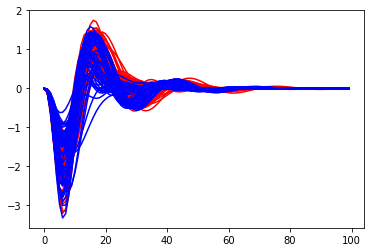

In [4]:
for I in PPD.index:
    plt.plot(NGD2LS_TK(T, *PPD.loc[I][:-1]),'r')
for I in NPD.index:
    plt.plot(NGD2LS_TK(T, *NPD.loc[I][:-1]),'b')

# Single Cell PvN to LPOU

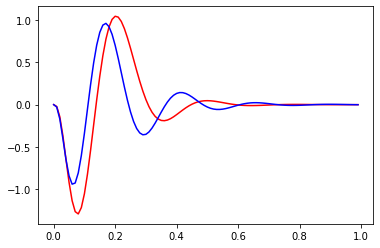

In [5]:
PIndex = np.argmin(PPD['error'])
NIndex = np.argmin(NPD['error'])

PTK = NGD2LS_TK(T, *PPD.loc[PIndex][:-1])
NTK = NGD2LS_TK(T, *NPD.loc[NIndex][:-1])

plt.plot(T, PTK,'r')
plt.plot(T, NTK,'b')

In [6]:
Tto = 300
LPOU = SSG([1], dt, Tto, tau = 1, D = 1)[0]
x = (LPOU-np.mean(LPOU))*2.+10.

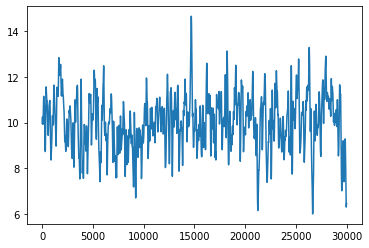

In [7]:
plt.plot(x)

In [8]:
cPTK =np.append(np.zeros(len(PTK)-1), PTK)
cNTK =np.append(np.zeros(len(NTK)-1), NTK)

Pr = np.convolve(x, cPTK, 'same')
Nr = np.convolve(x, cNTK, 'same')

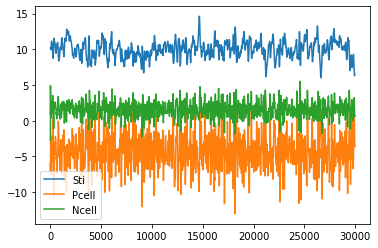

In [9]:
startwith = 40
plt.plot(x[startwith:], label='Sti')
plt.plot(Pr[startwith:],label='Pcell')
plt.plot(Nr[startwith:],label='Ncell')

plt.legend()
# plt.xlim([15000, 16000])

## STA

In [10]:
Auto = np.correlate(x, x, 'same')/np.correlate(np.ones_like(x), x, 'same')
Psta = np.correlate(x, Pr, 'same')/np.correlate(np.ones_like(x), Pr, 'same')
Nsta = np.correlate(x, Nr, 'same')/np.correlate(np.ones_like(x), Nr, 'same')

(14000, 16000)

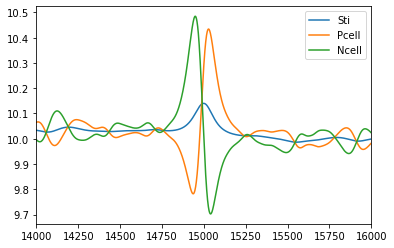

In [11]:
plt.plot(Auto, label='Sti')
plt.plot(Psta,label='Pcell')
plt.plot(Nsta,label='Ncell')
plt.legend()
plt.xlim([14000, 16000])

## MI

In [12]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
v = np.append(0, np.diff(LPOU))/dt
vstate = EqualState(v, state_num)[0]

In [13]:
r = NL(-Pr+np.mean(Pr), 0)
ratio = sum(r)/Tto/2
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [14]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

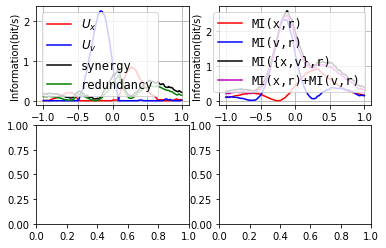

In [15]:
fig, ((ax2, ax3), (ax12, ax13)) = plt.subplots(nrows=2, ncols=2) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

#plot MIs
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.grid()
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [16]:
r = NL(-Nr+np.mean(Nr), 0)
ratio = sum(r)/Tto/2
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
ystate, _ = np.histogram(FakeSpike, np.arange(0,Tto+dt,dt))

In [17]:
window = [-1,1] # second
timeshift, Information = PIfunc(ystate, xstate, vstate, dt, window)

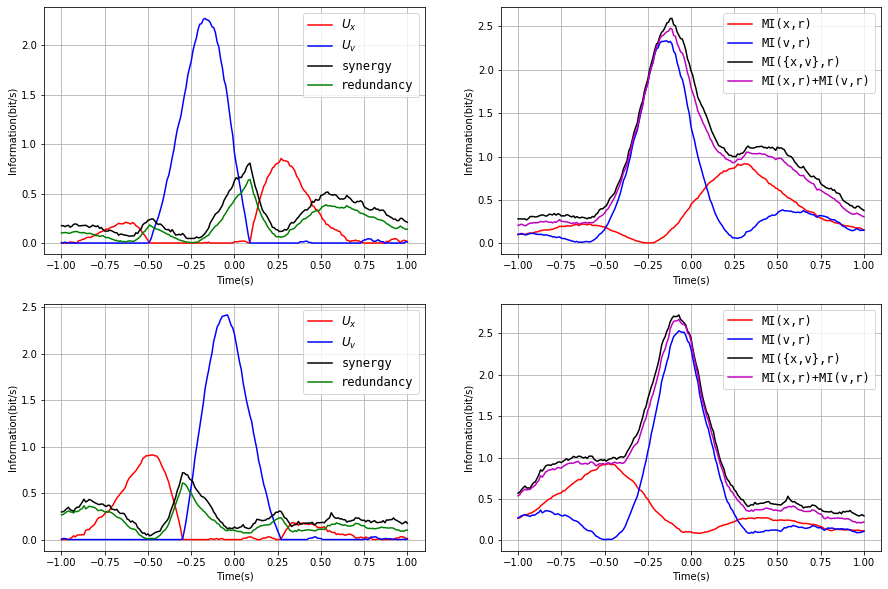

In [18]:
ax12.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax12.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax12.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax12.plot(timeshift,Information[('Beer','Red')], 'g-')
ax12.set_xlabel('Time(s)')
ax12.set_ylabel('Information(bit/s)')
ax12.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax12.grid()

#plot MIs
ax13.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax13.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax13.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]
         +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-')
ax13.plot(timeshift,Information[('Beer','UIx')]+2*Information[('Beer','Red')]+Information[('Beer','UIv')], 'm-')
ax13.set_xlabel('Time(s)')
ax13.set_ylabel('Information(bit/s)')
ax13.grid()
ax13.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 10)
fig